<a href="https://colab.research.google.com/github/vinodvicki/Appliance-Energy-Prediction/blob/main/Appliance_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Context

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes. The energy data was logged every 10 minutes with m-bus energy metres. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes. You need to predict the energy use of appliances.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets /Appliance Energy Prediction/data_application_energy.csv')

In [9]:
df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

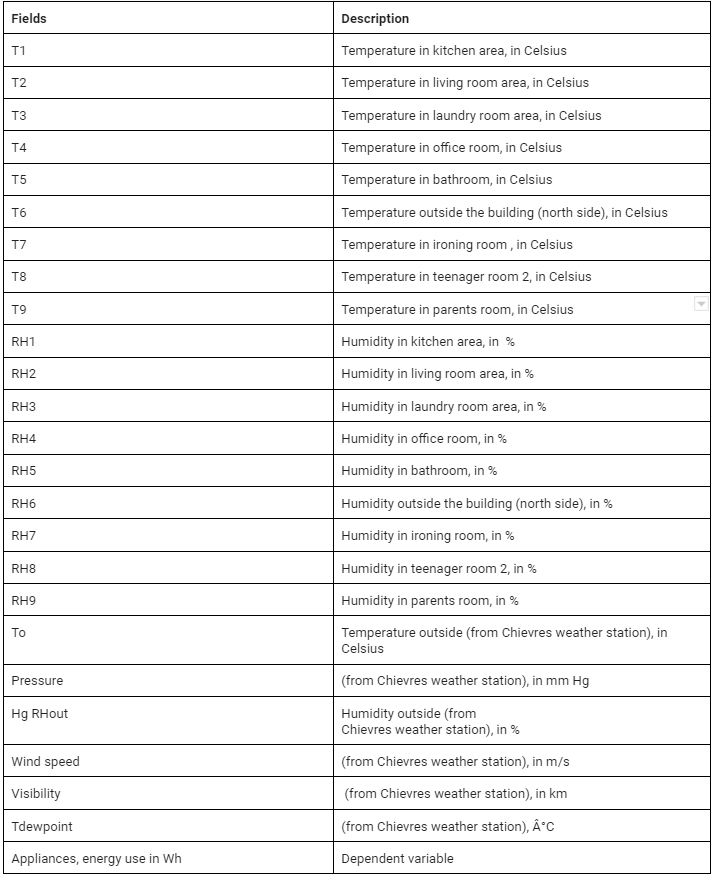

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [16]:
df['Appliances'].value_counts()

Appliances
50      4368
60      3282
40      2019
70      1560
80      1205
        ... 
890        1
1070       1
910        1
1080       1
840        1
Name: count, Length: 92, dtype: int64

In [21]:
df.describe().T

count        mean         std         min         25%  \
Appliances   19735.0   97.694958  102.524891   10.000000   50.000000   
lights       19735.0    3.801875    7.935988    0.000000    0.000000   
T1           19735.0   21.686571    1.606066   16.790000   20.760000   
RH_1         19735.0   40.259739    3.979299   27.023333   37.333333   
T2           19735.0   20.341219    2.192974   16.100000   18.790000   
RH_2         19735.0   40.420420    4.069813   20.463333   37.900000   
T3           19735.0   22.267611    2.006111   17.200000   20.790000   
RH_3         19735.0   39.242500    3.254576   28.766667   36.900000   
T4           19735.0   20.855335    2.042884   15.100000   19.530000   
RH_4         19735.0   39.026904    4.341321   27.660000   35.530000   
T5           19735.0   19.592106    1.844623   15.330000   18.277500   
RH_5         19735.0   50.949283    9.022034   29.815000   45.400000   
T6           19735.0    7.910939    6.090347   -6.065000    3.626667   
RH_6         19735.0   54.609083   31.149806    1.000000   30.025000   
T7           19735.0   20.267106    2.109993   15.390000   18.700000   
RH_7         19735.0   35.388200    5.114208   23.200000   31.500000   
T8           19735.0   22.029107    1.956162   16.306667   20.790000   
RH_8         19735.0   42.936165    5.224361   29.600000   39.066667   
T9           19735.0   19.485828    2.014712   14.890000   18.000000   
RH_9         19735.0   41.552401    4.151497   29.166667   38.500000   
T_out        19735.0    7.411665    5.317409   -5.000000    3.666667   
Press_mm_hg  19735.0  755.522602    7.399441  729.300000  750.933333   
RH_out       19735.0   79.750418   14.901088   24.000000   70.333333   
Windspeed    19735.0    4.039752    2.451221    0.000000    2.000000   
Visibility   19735.0   38.330834   11.794719    1.000000   29.000000   
Tdewpoint    19735.0    3.760707    4.194648   -6.600000    0.900000   
rv1          19735.0   24.988033   14.496634    0.005322   12.497889   
rv2          19735.0   24.988033   14.496634    0.005322   12.497889   

                    50%         75%          max  
Appliances    60.000000  100.000000  1080.000000  
lights         0.000000    0.000000    70.000000  
T1            21.600000   22.600000    26.260000  
RH_1          39.656667   43.066667    63.360000  
T2            20.000000   21.500000    29.856667  
RH_2          40.500000   43.260000    56.026667  
T3            22.100000   23.290000    29.236000  
RH_3          38.530000   41.760000    50.163333  
T4            20.666667   22.100000    26.200000  
RH_4          38.400000   42.156667    51.090000  
T5            19.390000   20.619643    25.795000  
RH_5          49.090000   53.663333    96.321667  
T6             7.300000   11.256000    28.290000  
RH_6          55.290000   83.226667    99.900000  
T7            20.033333   21.600000    26.000000  
RH_7          34.863333   39.000000    51.400000  
T8            22.100000   23.390000    27.230000  
RH_8          42.375000   46.536000    58.780000  
T9            19.390000   20.600000    24.500000  
RH_9          40.900000   44.338095    53.326667  
T_out          6.916667   10.408333    26.100000  
Press_mm_hg  756.100000  760.933333   772.300000  
RH_out        83.666667   91.666667   100.000000  
Windspeed      3.666667    5.500000    14.000000  
Visibility    40.000000   40.000000    66.000000  
Tdewpoint      3.433333    6.566667    15.500000  
rv1           24.897653   37.583769    49.996530  
rv2           24.897653   37.583769    49.996530

In [24]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [25]:
df.duplicated().sum()

0

## **EDA**

<function matplotlib.pyplot.show(close=None, block=None)>

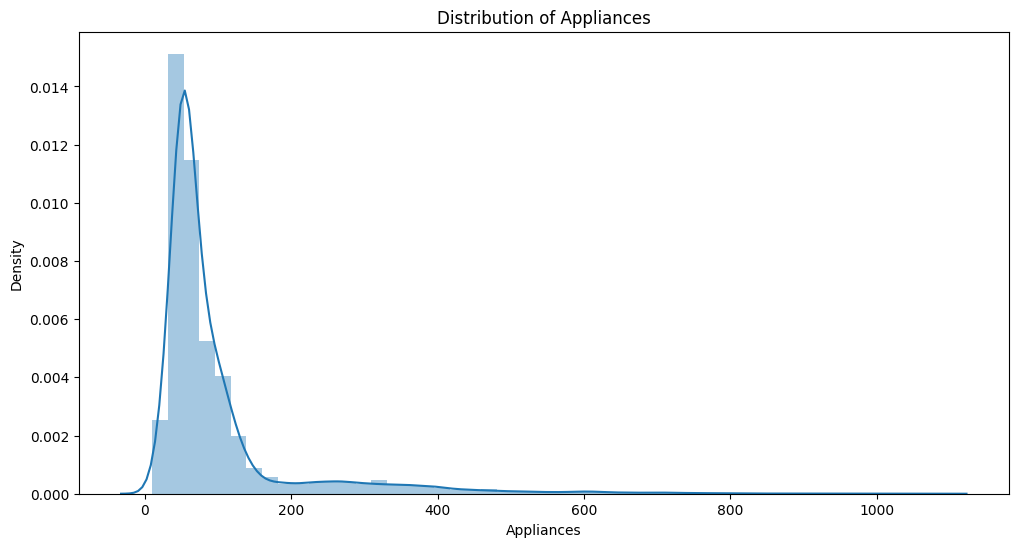

In [47]:
plt.figure(figsize=(12,6))
plt.title('Distribution of Appliances')
sns.distplot(df['Appliances'])
plt.show

In [39]:
import plotly.express as px

In [52]:
# prompt: using plotly.express plot the disturbution of every column

for col in df.columns[1:]:
  fig = px.histogram(df, x=col, title=f'Distribution of {col}')
  fig.show()


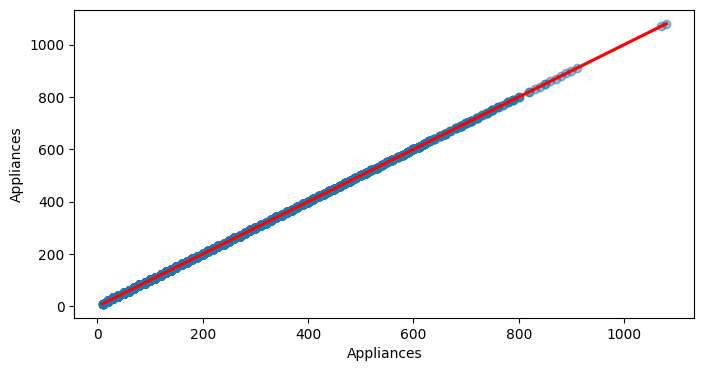

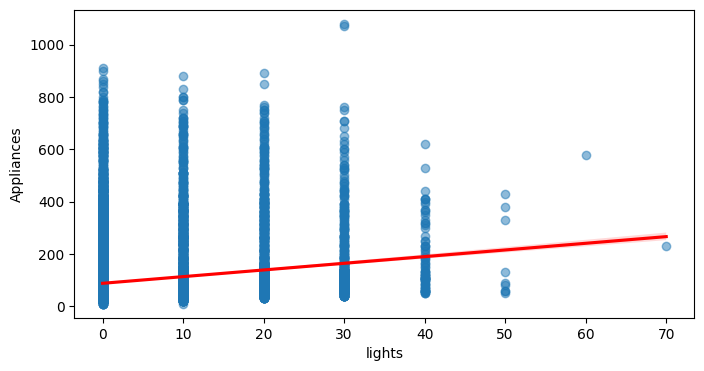

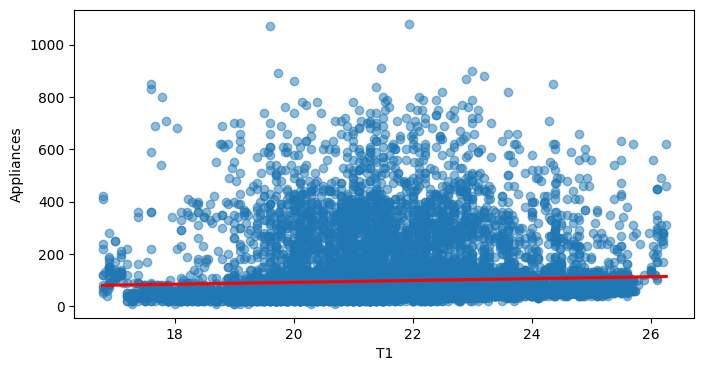

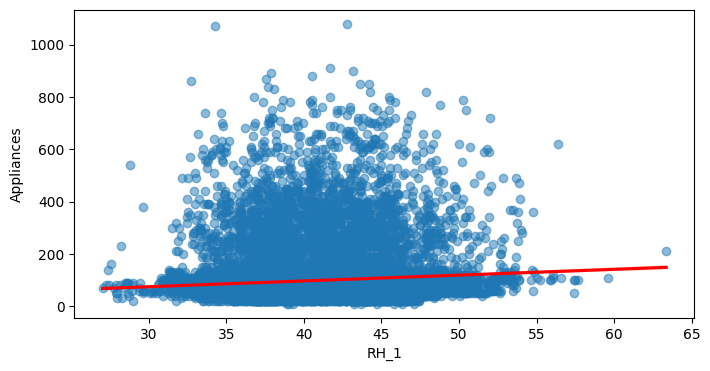

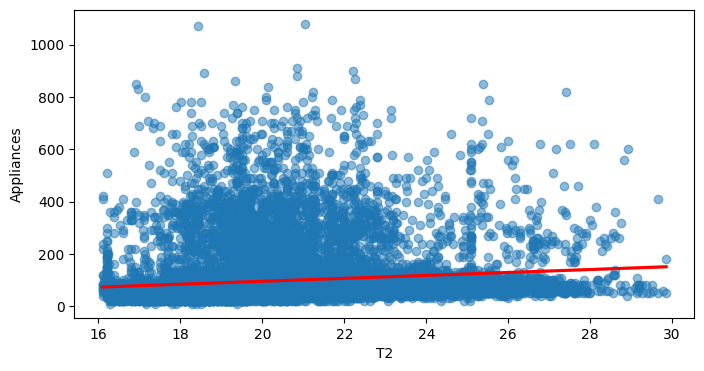

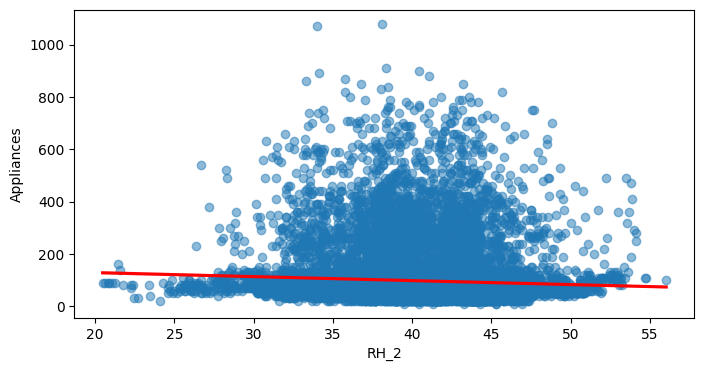

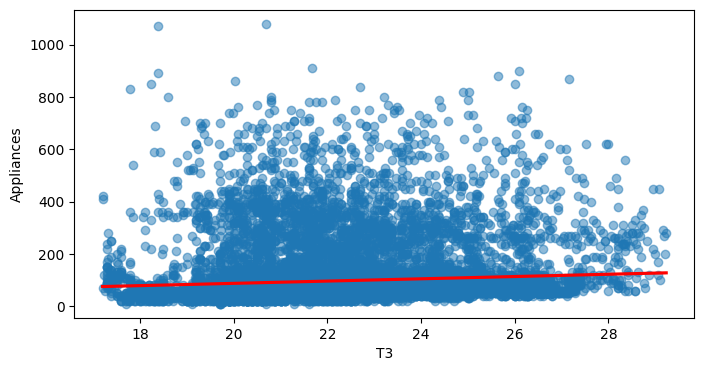

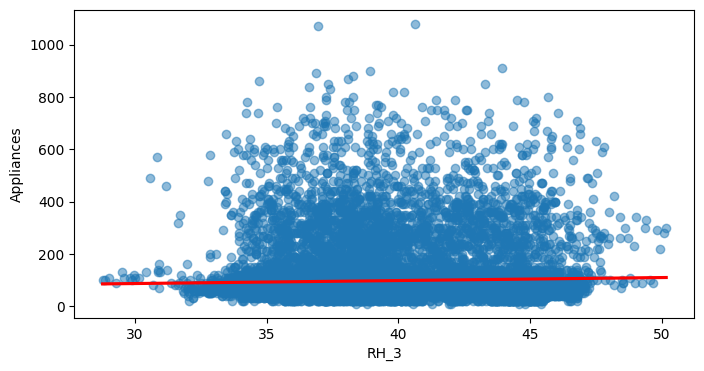

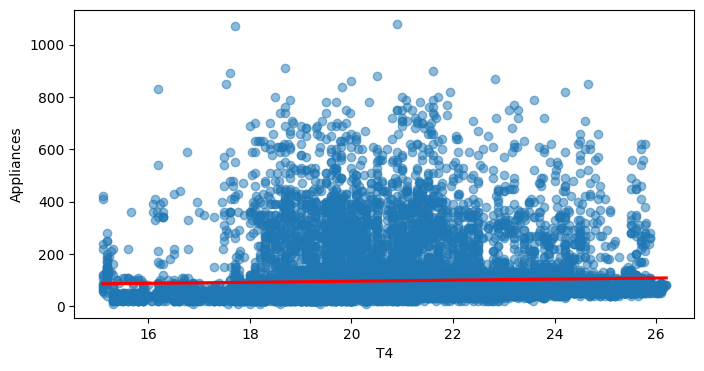

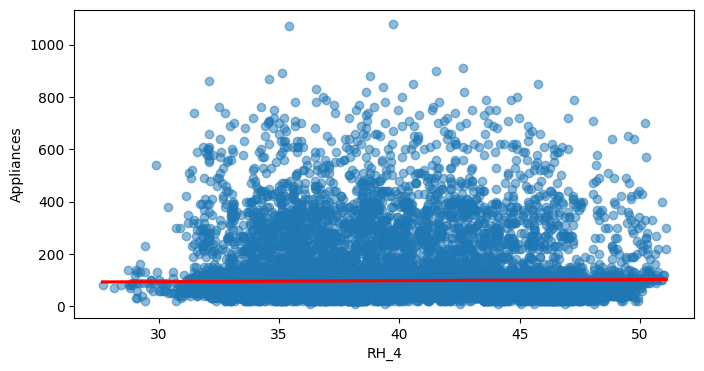

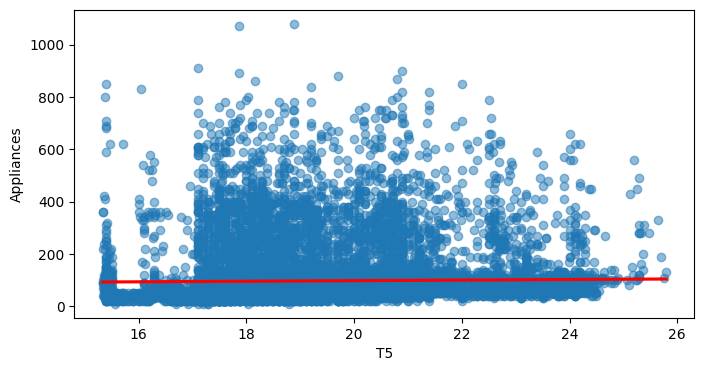

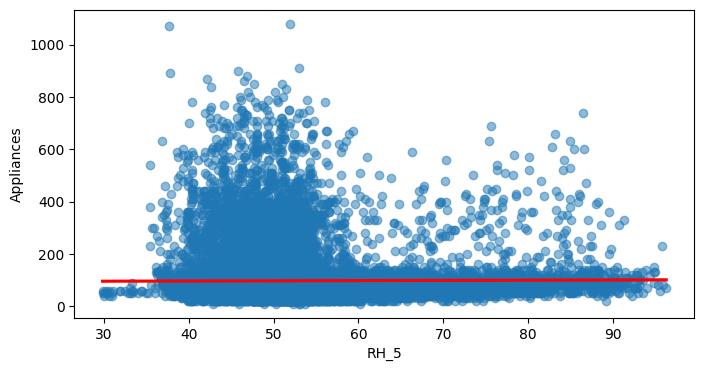

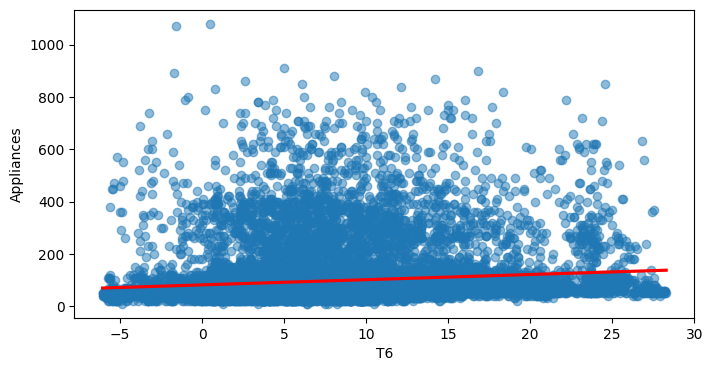

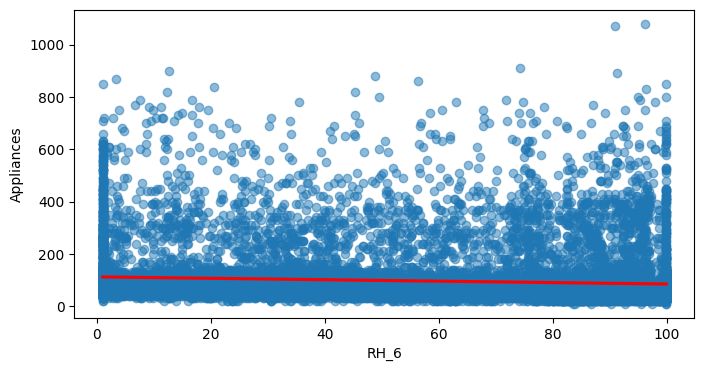

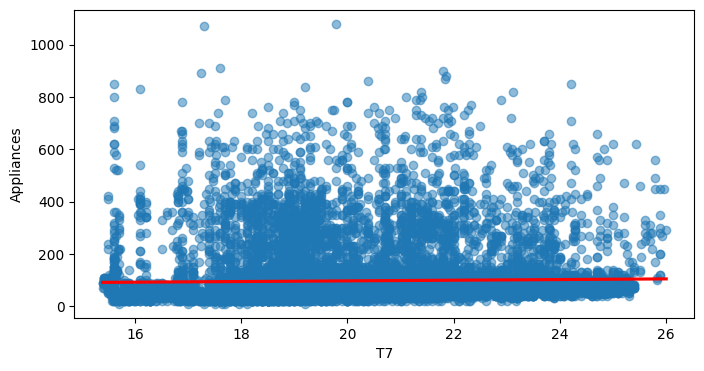

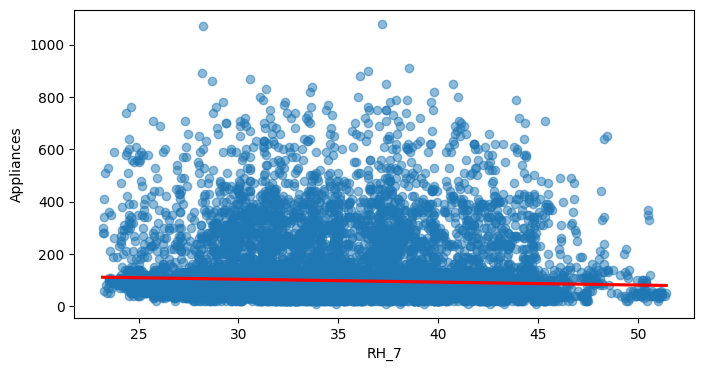

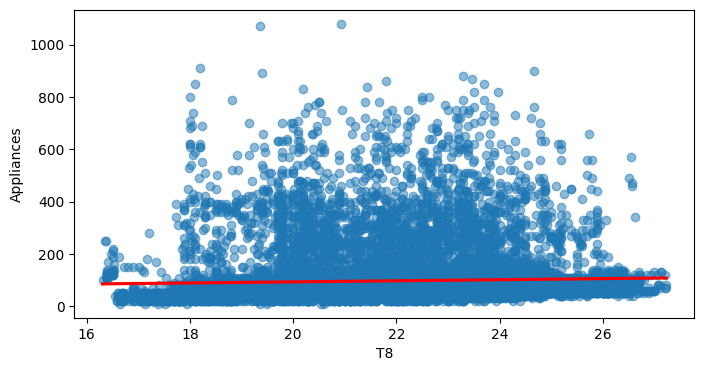

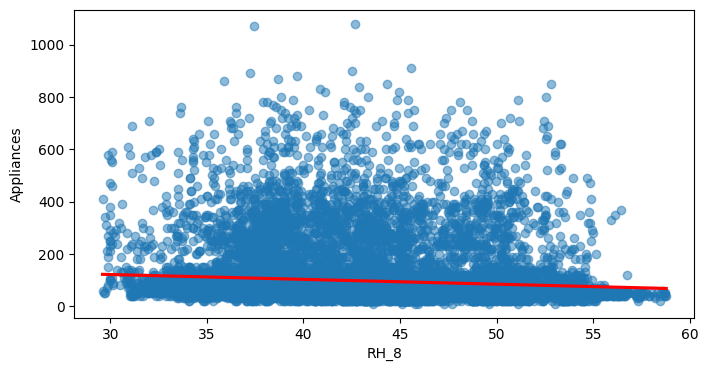

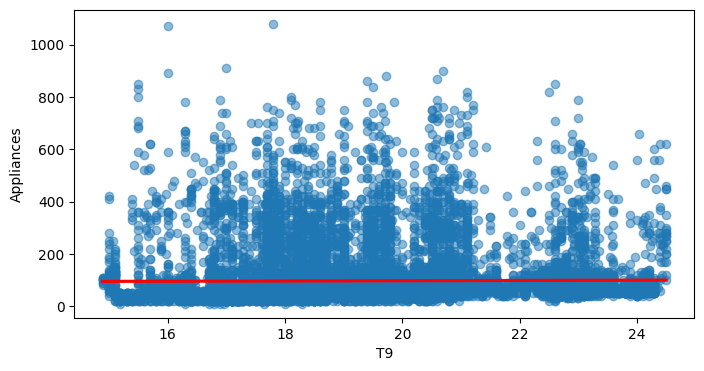

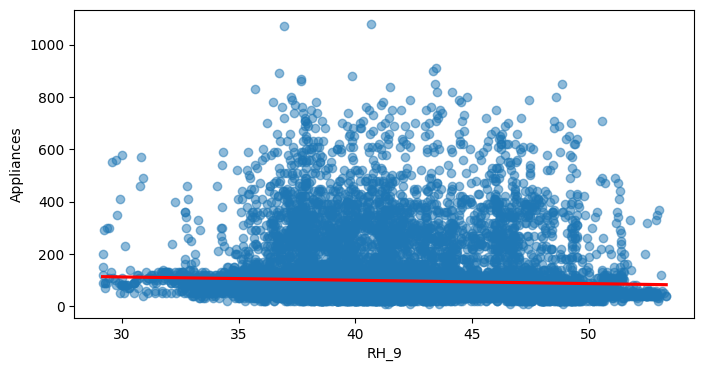

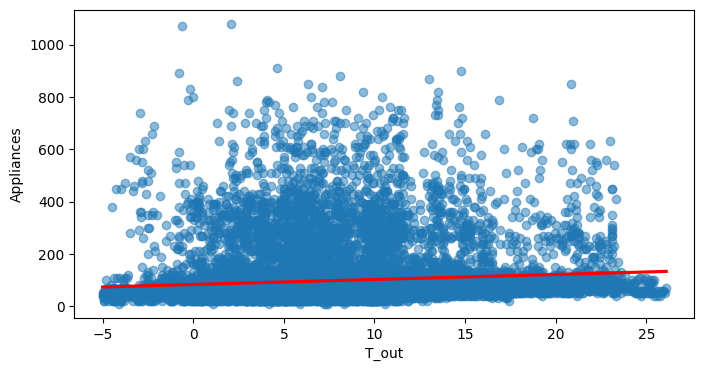

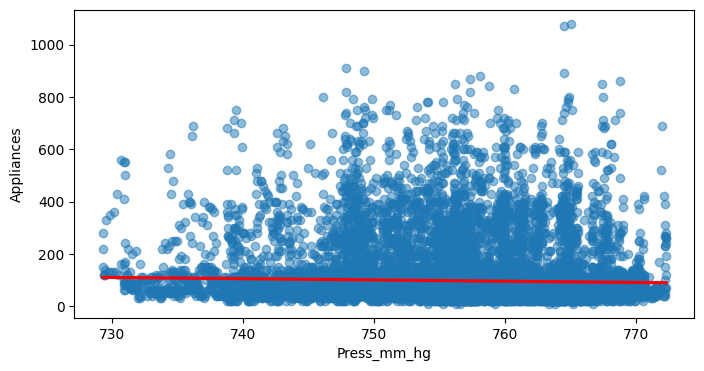

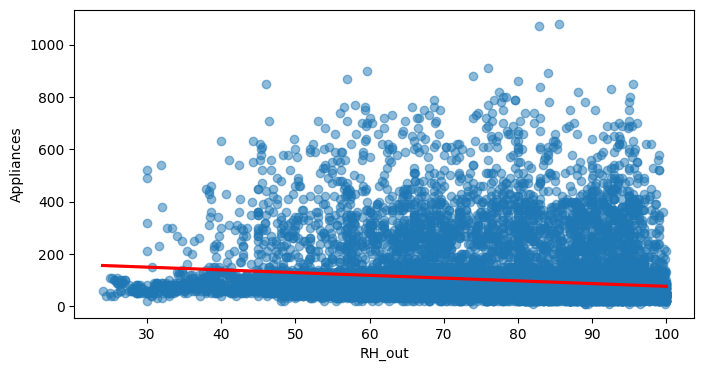

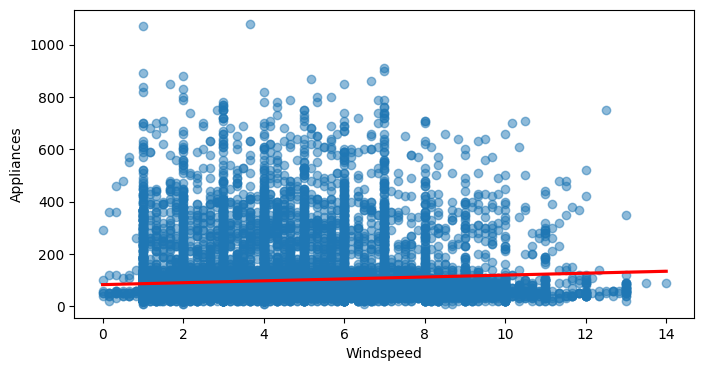

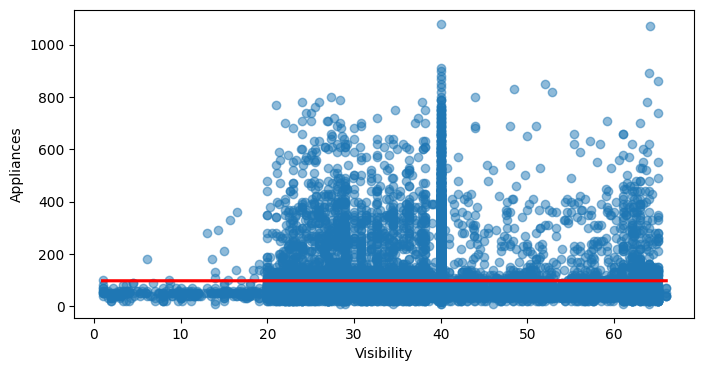

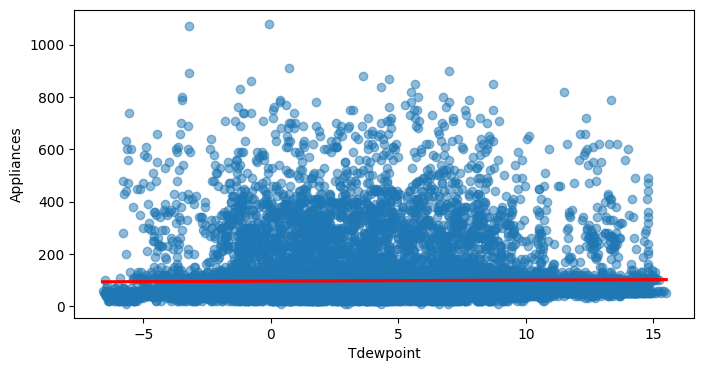

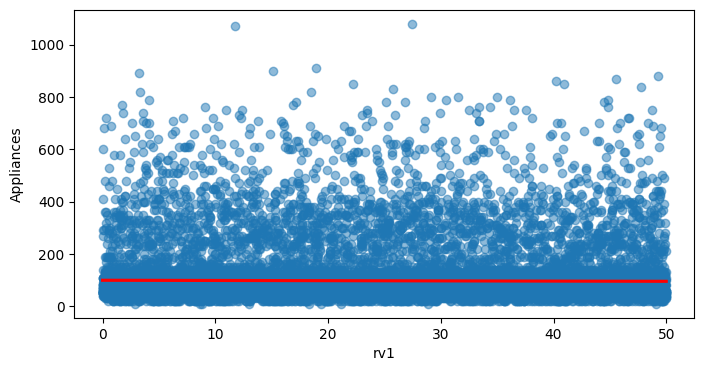

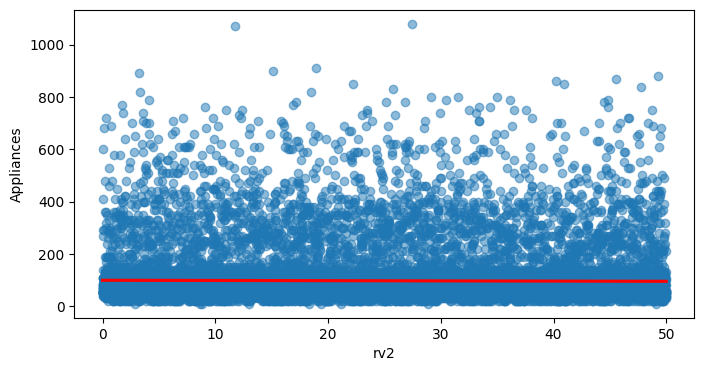

In [54]:
for i in df.columns[1:]:
  plt.figure(figsize=(8,4))
  sns.regplot(x= df[i],y= df['Appliances'],scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
  plt.show